In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Scalar ODE with 2 parameters

$$ y' = \beta exp(-\beta t) - \alpha y \quad y(0) = 0 $$

In [3]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_odeparams = 2

data = make_test_data_2()
#Times to evaluate the solution
times = data['t']

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_2, 
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

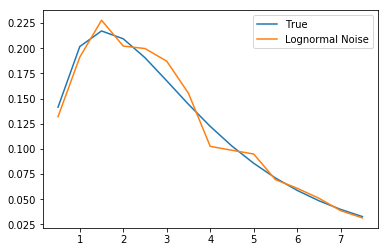

In [4]:
Ytrue = data['y']
Y = data['yobs']

plt.plot(times,Ytrue, label = 'True')
plt.plot(times,Y, label = 'Lognormal Noise')
plt.legend()


In [5]:

    
my_ODEop = ODEop(ode_model)


In [17]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha', 1)
    beta = pm.HalfNormal('beta', 1)

    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    #[ODE Parameters, initial condition]
    all_params = pm.math.stack([beta,alpha,0],axis=0)

    
    ode_sol = my_ODEop(all_params)

    
    forward = ode_sol.reshape(Y.shape)

    
    ode = pm.Deterministic('ode',ode_sol)
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)

    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [06:27<00:00, 10.30draws/s]


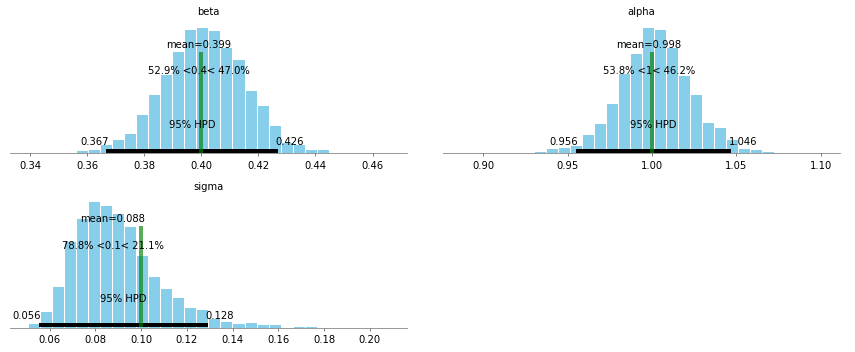

In [18]:
beta = data['p'][0]
alpha = data['p'][1]
sigma = data['sigma']


pm.posteriorplot.plot_posterior(trace,varnames = ['beta', 'alpha', 'sigma'], ref_val = [beta, alpha, sigma]);

In [20]:
pprint.pprint(pm.gelman_rubin(trace))

pprint.pprint(pm.effective_n(trace))

{'alpha': 0.9997787638427471,
 'beta': 0.999769238082343,
 'ode': array([0.99977391, 0.99977795, 0.99978119, 0.9997835 , 0.99978466,
       0.99978433, 0.99978208, 0.99977759, 0.99977112, 0.99976388,
       0.99975757, 0.99975326, 0.99975095, 0.99975008, 0.99975   ]),
 'sigma': 0.9997783927954703}
{'alpha': 2043.99311829564,
 'beta': 2087.880168625873,
 'ode': array([1962.86878062, 1869.09469747, 1809.67014006, 1781.80103341,
       1788.65782705, 1841.28378014, 1961.67636884, 2185.0044141 ,
       2551.12956866, 3062.01554428, 3604.81650492, 3980.21454355,
       4102.06588623, 3913.13337547, 3666.06901918]),
 'sigma': 2232.3061587856755}


In [22]:
with first_model:
    ppc = pm.sample_ppc(trace, 500)

/Users/demetri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 500/500 [00:09<00:00, 50.50it/s]


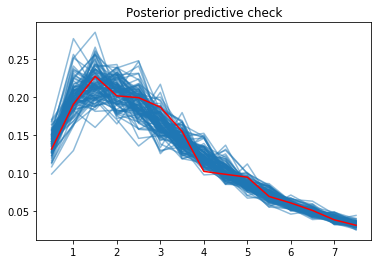

In [28]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,Y, color = 'red')
plt.title('Posterior predictive check');

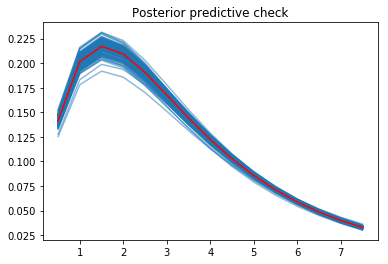

In [29]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i].reshape(Y.shape), color = 'C0', alpha = 0.5)
    
plt.plot(times,Ytrue, color = 'red')
plt.title('Posterior predictive check');